In [2]:
from models import TransformerModel
import torch
import lightning
import utils
import numpy as np


In [3]:
model = TransformerModel.load_from_checkpoint("transformer-logs/TNN_ne1_nd1_sl12_tl12_nh1_df64/checkpoints/epoch=31-step=1152.ckpt", map_location={"cuda:0": "cpu"})
model : TransformerModel
model


/home/unex/miniconda3/envs/tf/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
          )
          (linear1): Linear(in_features=4, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=4, bias=True)
          (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): N

In [4]:
import pandas as pd

# SEQ_LENGTH = 10
SEQ_LENGTH = 12

df_train, df_test, df_valid, mu, std = utils.load_cleaned_data()

df_concatenated = pd.concat([df_valid, df_train])
df_test_extended = pd.concat([df_concatenated.iloc[-SEQ_LENGTH:], df_test])


Mean Squared Error: 16.957309590016635
Root Mean Squared Error: 4.117925398792046


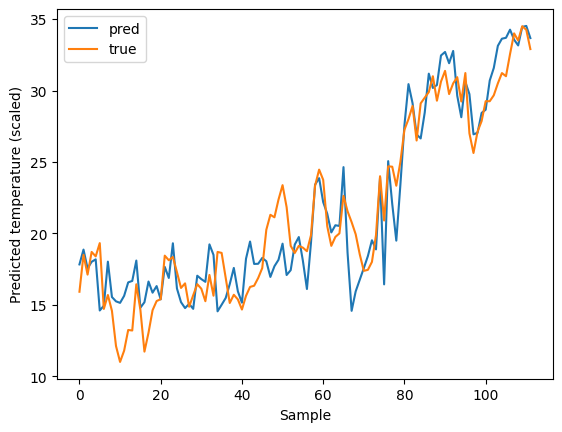

In [5]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error


dataloader_test = torch.utils.data.DataLoader(utils.ClimateDataset(df_test_extended, SEQ_LENGTH), batch_size=1, shuffle=False, num_workers=15)

preds, true = model.predict(dataloader_test)

preds = preds * std.to_numpy() + mu.to_numpy()
true = true * std.to_numpy() + mu.to_numpy()


true = true.reshape(true.shape[0], true.shape[-1])
preds = preds.reshape(preds.shape[0], preds.shape[-1])

mse = mean_squared_error(true, preds)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))
plt.plot(preds[:,0], label="pred")
plt.plot(true[:,0], label="true")
plt.xlabel('Sample')
plt.ylabel('Predicted temperature (scaled)')
plt.legend()
plt.show()


In [6]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error


dataloader_test = torch.utils.data.DataLoader(utils.ClimateDataset(df_test_extended, SEQ_LENGTH), batch_size=1, shuffle=False, num_workers=15)

x = torch.tensor(df_concatenated.iloc[-SEQ_LENGTH:].to_numpy().astype(np.float32)).unsqueeze(0)

preds = model.autoregressive_predict(x, df_test.shape[0])
preds = np.array(preds)




RuntimeError: value cannot be converted to type int64_t without overflow

Mean Squared Error: 106.26154635126686
Root Mean Squared Error: 10.30832412913306


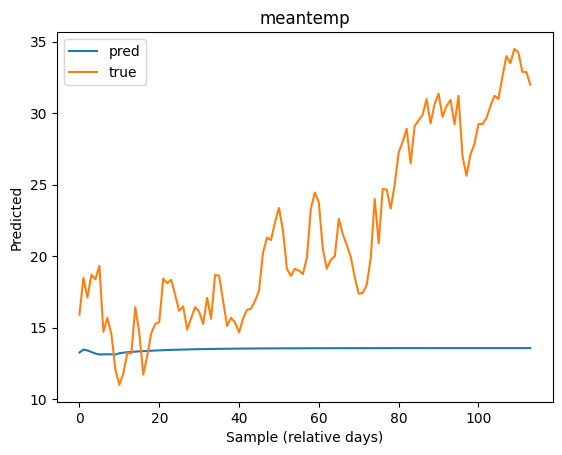

Mean Squared Error: 798.4235137804582
Root Mean Squared Error: 28.256388901989194


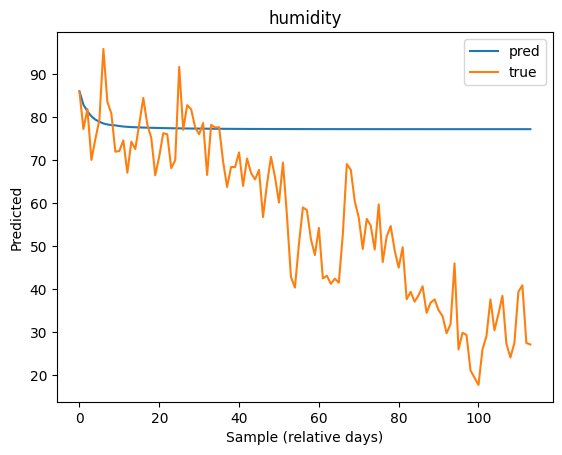

Mean Squared Error: 22.817102961370995
Root Mean Squared Error: 4.776725129350756


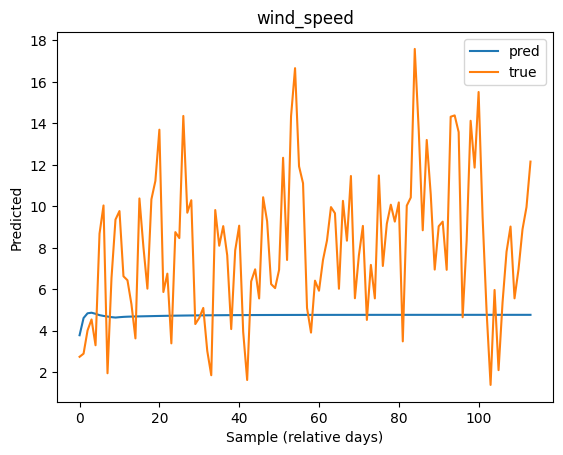

Mean Squared Error: 68.22209997374462
Root Mean Squared Error: 8.259667061918696


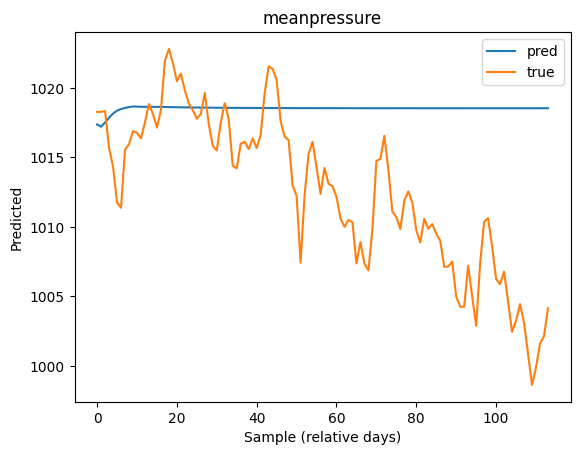

In [ ]:

true = df_test.to_numpy()

preds = preds * std.to_numpy() + mu.to_numpy()
true = true * std.to_numpy() + mu.to_numpy()


preds = preds.reshape(preds.shape[0], preds.shape[-1])

for i, name in enumerate(df_test.columns):
    mse = mean_squared_error(true[:,i], preds[:,i])
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", np.sqrt(mse))
    plt.plot(preds[:,i], label="pred")
    plt.plot(true[:,i], label="true")
    plt.xlabel('Sample (relative days)')
    plt.ylabel(f'Predicted')
    plt.title(name)
    plt.legend()
    plt.show()
